In [ ]:
import pypsa 
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

Set parameter Username
Set parameter LicenseID to value 2769009
Academic license - for non-commercial use only - expires 2027-01-22


Cannot find header.dxf (GDAL_DATA is not defined)


INFO:pypsa.network.index:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.network.io:Imported network '' has buses, carriers, generators, lines, links, loads, storage_units


{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x233835eefd0>},
 'branches': {'Link': <matplotlib.collections.LineCollection at 0x23382046490>,
  'Line': <matplotlib.collections.LineCollection at 0x23382046350>},
 'flows': {}}

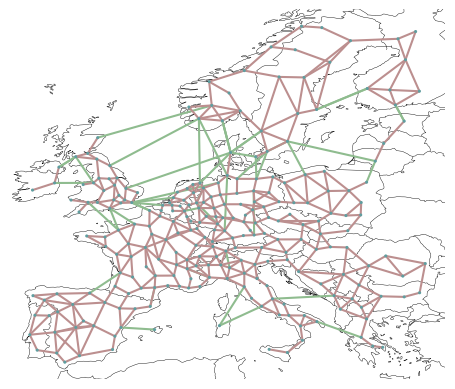

In [ ]:
# load network
#n = pypsa.Network("../data/networks/base.nc") # base has only lines, transformers and branches
n = pypsa.Network("../data/networks/elec_s_256_ec.nc")
# n = pypsa.Network("../data/networks/elec.nc")
# n = pypsa.Network("../pypsa-eur/results/test-elec/networks/base_s_6_elec_.nc")
# n = pypsa.Network("../pypsa-eur/resources/test-elec/networks/base.nc")

# plot network
n.plot.iplot() #instead of n.plot()

There are some problems with the networks from zenodo, because they were generated with pypsa 0.15. 
The networks that were generated ourselves are pypsa v1.0. So there are some differences in the exnaming 

In [ ]:
# in pypsa-eur hydro reservoirs are not modelled as generators but as storage units
#print(n.storage_units[n.storage_units["carrier"] == "hydro"].info()) # for pypsa 0.15 .nc files

# Storage-Units
print("Storage-Units:")
print(n.storage_units.info())

Storage-Units:
<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, AT0 0 hydro to SK0 1 H2
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   bus                                 721 non-null    object 
 1   control                             721 non-null    object 
 2   type                                721 non-null    object 
 3   p_nom                               721 non-null    float64
 4   p_nom_mod                           721 non-null    float64
 5   p_nom_extendable                    721 non-null    bool   
 6   p_nom_min                           721 non-null    float64
 7   p_nom_max                           721 non-null    float64
 8   p_nom_set                           0 non-null      float64
 9   p_min_pu                            721 non-null    float64
 10  p_max_pu                            721 non-null    float64
 11  p_set               

In [13]:
# Generators
print("\nGenerators:")
print(n.generators.info())


Generators:
<class 'pandas.core.frame.DataFrame'>
Index: 1453 entries, AL0 0 offwind-ac to SK0 1 solar
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bus                      1453 non-null   object 
 1   control                  1453 non-null   object 
 2   type                     1453 non-null   object 
 3   p_nom                    1453 non-null   float64
 4   p_nom_mod                1453 non-null   float64
 5   p_nom_extendable         1453 non-null   bool   
 6   p_nom_min                1453 non-null   float64
 7   p_nom_max                1453 non-null   float64
 8   p_nom_set                0 non-null      float64
 9   p_min_pu                 1453 non-null   float64
 10  p_max_pu                 1453 non-null   float64
 11  p_set                    0 non-null      float64
 12  e_sum_min                1453 non-null   float64
 13  e_sum_max                1453 non-null   float64

In [ ]:
print(n.storage_units.carrier)

name
AT0 0 hydro    hydro
AT0 1 PHS        PHS
AT0 1 hydro    hydro
AT0 2 PHS        PHS
AT0 2 hydro    hydro
               ...  
SE6 8 H2          H2
SE6 9 H2          H2
SI0 0 H2          H2
SK0 0 H2          H2
SK0 1 H2          H2
Name: carrier, Length: 721, dtype: object


In [7]:
print(n.generators[n.generators["carrier"] == "ror"]) # for pypsa 0.15 .nc files
# print(n.storage_units)

             bus control type        p_nom  p_nom_mod  p_nom_extendable  \
name                                                                      
AT0 0 ror  AT0 0                985.000000        0.0             False   
AT0 1 ror  AT0 1                511.420368        0.0             False   
AT0 2 ror  AT0 2                457.084663        0.0             False   
AT0 3 ror  AT0 3                384.000000        0.0             False   
AT0 4 ror  AT0 4               2247.000000        0.0             False   
...          ...     ...  ...          ...        ...               ...   
SE6 5 ror  SE6 5                 88.000000        0.0             False   
SE6 8 ror  SE6 8                390.000000        0.0             False   
SI0 0 ror  SI0 0                755.335000        0.0             False   
SK0 0 ror  SK0 0                613.480000        0.0             False   
SK0 1 ror  SK0 1                 27.850000        0.0             False   

           p_nom_min  p_

In [2]:
# First trys with ChatGPT to retrofit hydro generators to PHS
import pypsa
import pandas as pd
import numpy as np

# === Einstellungen / Annahmen ===
EFF_TURBINE = 0.9       # Turbine Wirkungsgrad
EFF_PUMP = 0.85         # Pumen Wirkungsgrad (Wirkungsgrad beim Aufpumpen)
RESERVOIR_HOURS = 24*7  # anfängliche Speicherkapazität als Stunden × p_nom (z.B. 1 Woche)
CAPEX_PHS_PER_MW = 1e6  # Beispiel-Investkosten EUR/MW (nur Platzhalter!)
CAPEX_RES_PER_MWH = 200e3  # EUR/MWh Speicherkapazität (Platzhalter)

# === Hilfsfunktionen ===
def identify_hydro_generators(n: pypsa.Network):
    # Beispiel-Filter: carrier == 'hydro'. Passe an falls anders markiert.
    if 'carrier' in n.generators.columns:
        hydro = n.generators[n.generators['carrier'] == 'hydro'].copy()
    else:
        # falls keine carrier-Spalte, you must adapt
        hydro = pd.DataFrame()
    return hydro

def compute_inflow_timeseries(gen, n: pypsa.Network):
    # zwei Fälle:
    # - wenn es eine time series p_max_pu (gen_t or p_max_pu) existiert: use it
    # - sonst, if there is per-generator profile in n.generators_t.p or similar.
    # Hier ein robustes Beispiel:
    if hasattr(n, "generators_t"):
        # p_max_pu * p_nom gives absolute available power each time step
        if 'p_max_pu' in n.generators_t.columns:
            return n.generators_t['p_max_pu'][gen.name] * gen.p_nom
        # falls p gen dispatch time-series vorhanden ist:
        if 'p' in n.generators_t.columns:
            return n.generators_t['p'][gen.name]  # reale Produktion -> als referenz
    # fallback: konstante sehr kleine inflow
    return pd.Series(0.0, index=n.snapshots)

# === Hauptroutine: Hydro -> PHS retrofit ===
def retrofit_hydro_to_phs(n: pypsa.Network, marker_tag="retrofit_candidate", remove_old=True):
    hydro = identify_hydro_generators(n)
    if hydro.empty:
        print("Keine Hydro-Generatoren gefunden (Filter anpassen).")
        return

    created = []
    for gid, gen_row in hydro.iterrows():
        gen = gen_row  # pandas Series
        bus = gen['bus']
        p_nom = float(gen.get('p_nom', 0.0))
        if p_nom <= 0:
            print(f"Generator {gid} hat p_nom<=0, übersprungen.")
            continue

        # inflow TS (Watt oder MW je nach Einheiten deines Netzes)
        inflow_ts = compute_inflow_timeseries(gen_row, n)  # pd.Series aligned to n.snapshots
        # Energiezufuhr pro Zeitschritt (MWh) - falls snapshots stündlich, multipliziere mit 1h
        # (Achte auf units in deinem network!)
        # --- einfache Heuristik für e_nom: RESERVOIR_HOURS * p_nom
        e_nom = p_nom * RESERVOIR_HOURS

        # Erstelle eindeutige Namen
        base_name = f"PHS_{gid}"
        storage_name = f"{base_name}_store"
        turbine_name = f"{base_name}_turb"
        pump_name = f"{base_name}_pump"

        # 1) StorageUnit (Reservoir)
        n.add("StorageUnit",
              name=storage_name,
              bus=bus,
              p_nom=None,            # doppelseitig gesteuert vom pump/turb
              e_nom=e_nom,
              efficiency_store=1.0,  # wenn du Verluste modellieren willst, setze <1
              standing_loss=0.0,
              capital_cost=CAPEX_RES_PER_MWH * e_nom)  # optional für Invest-Objekt

        # 2) Turbine (Erzeuger) - produziert Strom durch Entladung
        n.add("Generator",
              name=turbine_name,
              bus=bus,
              p_nom=p_nom,
              marginal_cost=0.0,
              efficiency=EFF_TURBINE,
              # falls du Investitionsentscheidung erlauben willst:
              p_nom_extendable=False,
              capital_cost=CAPEX_PHS_PER_MW * p_nom)  # optional

        # 3) Pump (neg. Erzeuger bzw. Verbraucher) - modelliert als "Link" oder "Generator" mit negative output
        # Empfehlung: Link component to model conversion from electricity to store (pump) and back (turbine).
        # We'll add two Links: pump: bus->store, turb: store->bus. If Link not supported, use Generator + Store power balance.
        # Use Link to represent conversion with efficiencies.
        n.add("Link",
              name=f"{base_name}_pump_link",
              bus0=bus,
              bus1=bus,  # if store is on same bus, we keep bus; or create virtual bus for store if needed
              p_nom=p_nom,
              efficiency=EFF_PUMP,
              capital_cost=CAPEX_PHS_PER_MW * p_nom)  # pump capex

        # Mark created items
        created.append({
            "gen_id": gid,
            "bus": bus,
            "p_nom": p_nom,
            "storage": storage_name,
            "turbine": turbine_name,
            "pump_link": f"{base_name}_pump_link"
        })

        # optional: kopieren von Metadaten / tags
        # z.B. markiere, dass der Standort retrofitfähig ist
        # (du kannst später auf diese Markierung filtern)
        if 'tags' in n.generators.columns:
            # das ist pseudo; du musst ggf. ein Feld anlegen oder n.meta verwenden
            pass

        # 4) Optional: entferne Generator (deferred until we processed all)
        if remove_old:
            n.remove("Generator", gid)

    print(f"PHS für {len(created)} Standorte erzeugt.")
    return created

# === Anwendung ===
n = pypsa.Network("../data/networks/elec_s_37.nc")  # zB .nc oder .yaml
created = retrofit_hydro_to_phs(n, remove_old=True)
# n.lopf(...)  # löse das Modell wie gewohnt


INFO:pypsa.network.index:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.network.io:Imported network '' has buses, carriers, generators, lines, links, loads, storage_units


Keine Hydro-Generatoren gefunden (Filter anpassen).
